<br>

# <center> Sentiment Analysis of Twitter Tweets using NLP and LSTM


<br>

---

<br>


# List of Contents



*   [1. Initialization](#initialization)
*   [2.Exploratory Data Analysis](#exploratory-data-analysis)
*   [3. Text Processing](#text-processing)
*   [4. Preprocessing](#preprocessing)
*   [5. Model Design](#model_design)
*   [6. Model Training](#model_training)
*   [7. Model Evaluaiton](#model_evaluaiton)
*   [8. Save Model](#save_model)
*   [9. Saving the required Data](#saving-the-required-data)


<br>


<br>

> Dataset is collected from Kaggle : [Twitter Tweets Sentiment Dataset](https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset).

<br>

<br>
<br>

<a name='initialization'></a>
# 1. Initialization

<br>

## 1.1. Colab Configuration

### 1.1.1. Mount Google Drive

In [1]:
'''
    This is required if the code runs in Google Colab.
    - this code will mount Google Drive for Colab.
    - the code needs to run only once.
'''

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<br>

### 1.1.2. Defining Root Directory

In [2]:
# -----------------------------------------------
#   Check the code is running on Colab or not   |
# -----------------------------------------------
import sys
is_running_on_colab = 'google.colab' in sys.modules


# -----------------------------------------------
#               Root Directory                  |
# -----------------------------------------------
# this directory will be used as Root Directory to read/write any file
if is_running_on_colab:
    # for google-colab
    rootDir = '/content/drive/MyDrive/_ML/Twitter Sentiment Analysis LSTM'
else:
    # for application
    rootDir = './mlData/'
    

<br>

## 1.2. Import Libraries

In [3]:
# importing all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

<br>

## 1.3. Import DataSet

<br> 

> Reading JSON DataSet

In [4]:
# defining the dataset path
dataset_path = f'{rootDir}/02. DataSet/Twitter Tweets Sentiment/Sentiment.csv'

# reading the csv dataset
data = pd.read_csv(dataset_path)

In [5]:
# keeping only the neccessary columns
df = data[['text','sentiment']].copy()

In [6]:
# display the dataset
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


<br>
<br>

<a name='exploratory-data-analysis'></a>

# 2. Exploratory Data Analysis

> Dealing with missing values

In [7]:
# checking the missing values
df.isna().sum()

text         1
sentiment    0
dtype: int64

In [8]:
# droping the missing values
df.dropna(axis=0, inplace=True)

<br>

> Data Visualisation - Bar Plot

<Axes: xlabel='sentiment'>

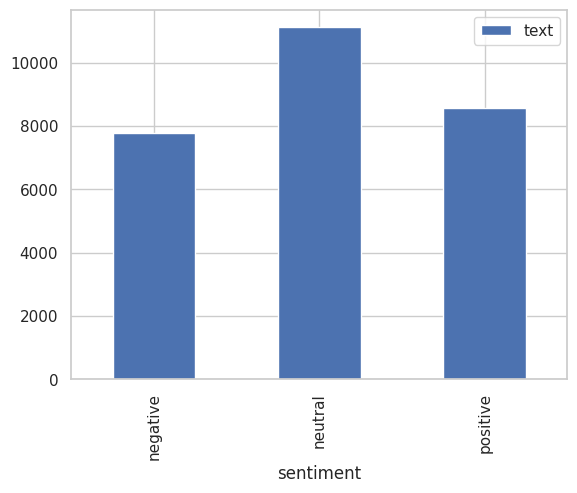

In [9]:
# setting the theme
sns.set_theme(style="whitegrid")

# The distribution of sentiments
df.groupby('sentiment').count().plot(kind='bar')

<br>

> Data Visualisation - Pie Chart

In [10]:
# importing the library
import plotly.express as px

# plotting the figure
fig = px.pie(df, names='sentiment', title ='Pie chart of different sentiments of tweets', width=800)
fig.show()

<br>
<br>

<a name='text-preprocessing'></a>

# 3. Text Processing

## 3.1. Filtering the text

In [11]:
# importing regex library
import re   

<br>

### 3.1.1. Filter Design

In [12]:
# defining the function to filter tweets
def filter_text(
        text: str
    ):

    '''
        Filtering the tweet string to extract meaningful text.
        

        Parameter
        ---------
        text
            a text (string)

        Return
        ------
        ret
            filtered tweet string
    '''


    # 01. converting the text to lower case
    text = text.lower()

    # 02. filtering non-letters from the text so only valid words remain
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)

    # 03. removes a specific word from text if exists
    word_to_remove = 'rt' # defining the word to remove
    # text = re.sub(r'\b' + word_to_remove + r'\b', '', text)

    # 04. striping the white space at starting or end of the text
    text = text.strip()


    # returning the filtered text
    return text

<br>

> Filter Outcome

In [13]:
# displaying the outcome of the filtering
test_tweet = df['text'][3]

print(f"Before filter : \n '{ test_tweet }'")
print('\n')
print(f"After filter : \n '{ filter_text(test_tweet) }'")

Before filter : 
 ' what interview! leave me alone'


After filter : 
 'what interview  leave me alone'


<br>

### 3.1.2. Applying the filter to the dataset

In [14]:
# filtering all the tweet text in the dataset
df['text'] = df['text'].apply( filter_text )

# dispalying the dataset after filter
df.head()

,text,sentiment
0,i d have responded if i were going,neutral
1,sooo sad i will miss you here in san diego,negative
2,my boss is bullying me,negative
3,what interview leave me alone,negative
4,sons of why couldn t they put them on th...,negative


<br>

## 3.2. NLP

<br>

### 3.2.1. Initializing NLTK

In [15]:
import nltk

In [16]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

<br>

### 3.2.2. Lemmatizer Design

<br>

> Designing Parts-Of-Speech Tagger

In [17]:
# accessing the wordnet library for parts-of-speech tagging
from nltk.corpus import wordnet

# defining function for POS tagging of a word
def get_wordnet_pos(word):
    '''
        Map POS tag to first character the WordNetLemmatizer() function accepts

        Parameters
        ----------
        word
            the word whose Parts-Of-Speech will be tagged

        Return
        ------
        ret
            tagged Parts-Of-Speech of the word
    '''
    
    # accessing the first alphabet
    tag = nltk.pos_tag([word])[0][1][0].lower()
    
    # definning the dictionary
    tag_dict = {
        "a": wordnet.ADJ,
        "n": wordnet.NOUN,
        "v": wordnet.VERB,
        "r": wordnet.ADV
    }
    
    # getting the tagged parts-of-speech
    pos = tag_dict.get(tag, wordnet.NOUN)
    
    # returning the tagged pos
    return pos

<br>

> Desiging Lemmatizer

In [18]:
from nltk.stem import WordNetLemmatizer

def _lemmatize(sentence):
    '''
        Lemmatize the words of a sentence.

        Parameters
        ----------
        sentence
        the sentence whose words will be lemmatized

        Return
        ------
        ret
        lemmatized sentence
    '''
        
    # creating the lemmatizer
    lemmatizer = WordNetLemmatizer()

    # definign list to store the lemmatized words
    lemmatized_words = []
        
    # looping through the words of the sentence to lemmatize
    for word in sentence.split():
        # parts-of-speech of the word
        pos = get_wordnet_pos(word)
        
        # lemmatized word
        lemma = lemmatizer.lemmatize(word=word, pos=pos)
        
        # appending the lemmatized word to the list
        lemmatized_words.append(lemma.lower())

    # creating the sentence with lemmatized words
    lemmatized_sentence = ' '.join(lemmatized_words)

    # returning the lemmatized sentence
    return lemmatized_sentence

<br>

> Lemmatizer Outcome

In [19]:
# displaying the outcome of the lemmatizer
test_tweet = df['text'][3]

print(f"Before lemmatize : \n '{ test_tweet }'")
print('\n')
print(f"After lemmatize : \n '{ _lemmatize(test_tweet) }'")

Before lemmatize : 
 'what interview  leave me alone'


After lemmatize : 
 'what interview leave me alone'


<br>

### 3.2.3. Applying NLP

In [20]:
# lemmatizing all the tweet text in the dataset
df['text'] = df['text'].apply( _lemmatize )

# dispalying the dataset after lemmatize
df.head()

,text,sentiment
0,i d have respond if i be go,neutral
1,sooo sad i will miss you here in san diego,negative
2,my bos be bullying me,negative
3,what interview leave me alone,negative
4,son of why couldn t they put them on the relea...,negative


<br>

## 3.3. Tokenizing & Padding

In [21]:
# accessing the library for tokenizing and padding
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

<br>

### 3.3.1. Defining the parameter

In [22]:
# extracting the length of each sequence
length_all = [len(text.split()) for text in df['text']]

# extracting the max length
max_length = max(length_all)

# rounding the max length to nearest integer
max_length = int(np.ceil(max_length/10.0) * 10)

# defining the max word limit
max_words = 50000

In [23]:
# defining the config
config = {
    'vocab_size' : max_words,
    'max_length' : max_length,
}

In [24]:
print(f"vocab_size : {config['vocab_size']}")
print(f"max_length : {config['max_length']}")

vocab_size : 50000
max_length : 40


> The config is saved as pickle file at the end of the code

<br>

### 3.3.2. Defining the function for tokenize and padding

In [25]:
def tokenize_pad_sequence(sentences, vocab_size, max_length):
    '''
        This function tokenize the input text into sequnences of intergers and 
        then pad each sequence to the same length.

        Parameter
        ---------
        sentence
            the sentence that will be tokenized and padded
        
        vocab_size
            the number of most frequent words to be included in the vocabulary
        
        max_length
            maximum length of the sequence

        Return
        ------
        ret
            padded sequence
    '''

    # 01. Text tokenization
    tokenizer = Tokenizer(num_words = vocab_size, lower = True, split = ' ')
    tokenizer.fit_on_texts(sentences)
    
    # 02. Transforms text to a sequence of integers
    tokens = tokenizer.texts_to_sequences(sentences)
    
    # 03. Pad sequences to the same length
    padded_tokens = pad_sequences(tokens, padding = 'post', maxlen = max_length)
    
    # return sequences and tokenizer
    return padded_tokens, tokenizer

<br>

> Tokenizing and Padding Outcome

In [26]:
# accessing one data
test_tweet = df['text']
index = 3

# displaying the outcome of the lemmatizer
print(f"Before tokenizing and padding : \n '{ test_tweet[index] }'")
print('\n')
print(f"After tokenizing and padding : \n ")
seq, tokenizer = tokenize_pad_sequence(test_tweet, config['vocab_size'], config['max_length'])
seq[index]

Before tokenizing and padding : 
 'what interview leave me alone'


After tokenizing and padding : 
 


array([  51, 1007,  237,   18,  485,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

<br>

### 3.3.3. Applying Tokenizing and Padding

In [27]:
# tokenizng and padding all the tweet text in the dataset
sequence, tokenizer = tokenize_pad_sequence(test_tweet, config['vocab_size'], config['max_length'])

# adding the padded token in the dataset
df['sequence'] = pd.Series( sequence.tolist() )

# dispalying the dataset after filter
df.head()

,text,sentiment,sequence
0,i d have respond if i be go,neutral,"[1, 158, 10, 1389, 73, 1, 2, 20, 0, 0, 0, 0, 0..."
1,sooo sad i will miss you here in san diego,negative,"[407, 121, 1, 62, 58, 8, 91, 11, 1390, 2127, 0..."
2,my bos be bullying me,negative,"[7, 1303, 2, 8873, 18, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,what interview leave me alone,negative,"[51, 1007, 237, 18, 485, 0, 0, 0, 0, 0, 0, 0, ..."
4,son of why couldn t they put them on the relea...,negative,"[713, 15, 112, 461, 14, 72, 279, 131, 19, 4, 9..."


> The tokenizer is saved as pickle file at the end of the code

<br>

# 4. Preprocessing

<br>

## 4.1. Target Manipulation

<br>

### 4.1.1. Label Encoding of the target

In [28]:
# accessing the class-names
df['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [29]:
# defining the class-names in the targets
target_names = [name.capitalize() for name in df['sentiment'].unique()]

print(f'Target Names : {target_names}')

Target Names : ['Neutral', 'Negative', 'Positive']


In [30]:
# defining the encoder for hot-encoding
encoder = { class_name.lower(): index for index, class_name in enumerate(target_names) }

print(f'Encoder : {encoder}')

Encoder : {'neutral': 0, 'negative': 1, 'positive': 2}


In [31]:
# encoding the target
df['sentiment'] = df['sentiment'].map(encoder)

In [32]:
# dispalying the dataset after filter
df.head()

,text,sentiment,sequence
0,i d have respond if i be go,0,"[1, 158, 10, 1389, 73, 1, 2, 20, 0, 0, 0, 0, 0..."
1,sooo sad i will miss you here in san diego,1,"[407, 121, 1, 62, 58, 8, 91, 11, 1390, 2127, 0..."
2,my bos be bullying me,1,"[7, 1303, 2, 8873, 18, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,what interview leave me alone,1,"[51, 1007, 237, 18, 485, 0, 0, 0, 0, 0, 0, 0, ..."
4,son of why couldn t they put them on the relea...,1,"[713, 15, 112, 461, 14, 72, 279, 131, 19, 4, 9..."


<br>

### 4.1.2. Convert the Target to Categorical

In [33]:
# importing the library
from keras.utils import to_categorical

In [34]:
# converting to categorical
targets = to_categorical(df['sentiment'], dtype='int32')

# adding the targets to the dataframe
df['targets'] = pd.Series(targets.tolist())

In [35]:
# dispalying the targets after converting to categorical
df[['sentiment','targets']]

,sentiment,targets
0,0,"[1, 0, 0]"
1,1,"[0, 1, 0]"
2,1,"[0, 1, 0]"
3,1,"[0, 1, 0]"
4,1,"[0, 1, 0]"
...,...,...
27476,1,"[0, 1, 0]"
27477,1,"[0, 0, 1]"
27478,2,"[0, 0, 1]"
27479,2,"[1, 0, 0]"


<br>

## 4.2. Train Test Split

In [36]:
# importing the library
from sklearn.model_selection import train_test_split

In [37]:
# defining the data and targets
X = sequence
y = targets

In [38]:
# splitting the dataset into 20% for testing and the rest 80% for the training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# further splitting the training data into 25% for validation and the rest 75% for the actual training
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

In [39]:
# displaying the data count of trining, validation, and testing
print(f"Train data shape      : {X_train.shape}")
print(f"Validation data shape : {X_val.shape}")
print(f"Test Data shape       : {X_test.shape}")

Train data shape      : (17312, 40)
Validation data shape : (7420, 40)
Test Data shape       : (2748, 40)


<br>
<br>

<a name='model_design'></a>

# 5. Model Design

In [40]:
# importing libraries for model design
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM
from keras.layers import Dense, Activation, Dropout

In [41]:
# checking the shape of the training data
X_train.shape

(17312, 40)

<br>

## 5.1. Creating Model

In [42]:
# creating a LSTM
model = Sequential()

model.add( Embedding(input_dim = config['vocab_size'], output_dim = 256, input_length = config['max_length']) )
model.add( Dropout(0.15) )

model.add( LSTM(units=64, return_sequences=True) )
model.add( Dropout(0.35) )

model.add( LSTM(units=64, return_sequences=True) )
model.add( Dropout(0.4) )

model.add( LSTM(units=16) )
model.add( Dropout(0.3) )

model.add( Dense(units=128, activation='linear') )
model.add( Dropout(0.1) )

model.add( Dense(units=16, activation='linear') )
model.add( Dropout(0.5) )

model.add( Dense(units=64, activation='linear') )
model.add( Dropout(0.25) )

model.add( Dense(units=128, activation='linear') )
model.add( Dropout(0.1) )

model.add( Dense(3, activation='softmax') )

<br>

## 5.2. Compiling The Model

In [43]:
# Compiling the model
model.compile(
    loss='categorical_crossentropy',
    metrics = ['accuracy'],
    optimizer='Adam'
  )

In [44]:
# summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 256)           12800000  
                                                                 
 dropout (Dropout)           (None, 40, 256)           0         
                                                                 
 lstm (LSTM)                 (None, 40, 64)            82176     
                                                                 
 dropout_1 (Dropout)         (None, 40, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 40, 64)            33024     
                                                                 
 dropout_2 (Dropout)         (None, 40, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 16)                5

<br>
<br>

<a name='model_training'></a>

# 6. Model Training

<br>

## 6.1. Defining Callback

In [45]:
# importing early stopping callbacks from keras
from keras.callbacks import EarlyStopping

# defining early stopping
early_stop = EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min', 
    min_delta = 0.001, # minimium amount of change to count as an improvement
    verbose = 1, 
    patience = 20,
    restore_best_weights = True, 
  )

<br>

## 6.2. Training The Model

In [46]:
# training the LSTM
model.fit(
    x = X_train,
    y = y_train ,
    batch_size = 32,    
    epochs = 60,
    validation_data = (X_val, y_val),
    verbose = 1,
    callbacks = [early_stop]
  )

Epoch 1/60
541/541 [==============================] - 133s 236ms/step - loss: 1.0575 - accuracy: 0.4348 - val_loss: 0.8701 - val_accuracy: 0.6142
Epoch 2/60
541/541 [==============================] - 129s 238ms/step - loss: 0.8176 - accuracy: 0.6446 - val_loss: 0.7476 - val_accuracy: 0.6805
Epoch 3/60
541/541 [==============================] - 131s 241ms/step - loss: 0.6515 - accuracy: 0.7510 - val_loss: 0.7196 - val_accuracy: 0.6904
Epoch 4/60
541/541 [==============================] - 130s 240ms/step - loss: 0.5201 - accuracy: 0.8179 - val_loss: 0.7769 - val_accuracy: 0.6950
Epoch 5/60
541/541 [==============================] - 130s 241ms/step - loss: 0.4220 - accuracy: 0.8593 - val_loss: 0.8663 - val_accuracy: 0.6956
Epoch 6/60
541/541 [==============================] - 129s 239ms/step - loss: 0.3456 - accuracy: 0.8965 - val_loss: 0.8784 - val_accuracy: 0.6654
Epoch 7/60
541/541 [==============================] - 129s 239ms/step - loss: 0.2873 - accuracy: 0.9147 - val_loss: 1.1444 -

<br>
<br>

<a name='model_evaluaiton'></a>

# 7. Model Evaluaiton

<br>

## 7.1. Visualizing Loss Analysis

In [47]:
# accessing history
model_loss = pd.DataFrame( model.history.history )

# keeping one copy
model_loss_copy = model_loss.copy()

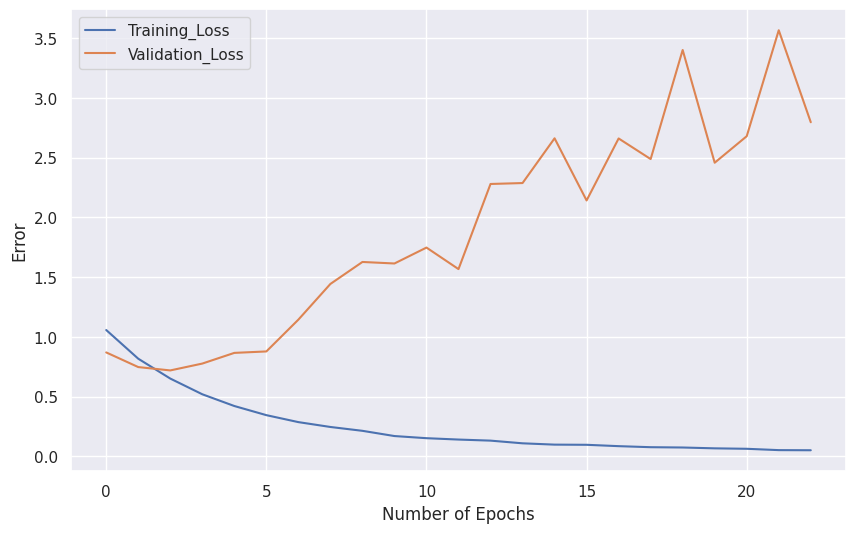

In [48]:
# defining the parameter
font_size = 12
fig_size = (10,6)

# plotting the history
sns.set_theme(style="darkgrid")
model_loss.columns = ['Training_Loss', 'Accuracy', 'Validation_Loss', 'Validation_Accuracy']
model_loss[['Training_Loss', 'Validation_Loss']].plot(figsize = fig_size)

# defining the label names for X-axis and Y-axis
plt.xlabel("Number of Epochs", fontsize = font_size)
plt.ylabel("Error", fontsize = font_size)

# saving the plot
dpi = 1200
image_name = 'Loss_Curve'
image_save_path = f'{rootDir}/03. Generated Data/Plots/{image_name}'
plt.savefig(image_save_path, dpi=dpi, pad_inches=0.2, bbox_inches='tight')

<br>

## 7.2. Classification Report and Confusion Matrix

<br>

#### Preparing Data

In [ ]:
# copying the original X and y test data
X_test_new = X_test.copy()
y_test_new = y_test.copy()

In [ ]:
def fill_missing_class() :
  '''
    This function will fill any Class missing in 'y_test'.
    The sklearn Train_Test_Split generates Train and Test Data randomly. So any classes might be missed in the Test Data.
  '''

  # accessing the global numpy array to write
  global X_test_new
  global y_test_new

  # finding the classes in train and test data
  yTrainArgmax = set( y_train.argmax(axis=1) )
  yTestArgmax = set( y_test.argmax(axis=1) )

  # finding the intent classes missing in 'y_test' by comparing with 'y_train'
  missing_classes = yTrainArgmax.difference(yTestArgmax)
  
  # convering to List
  missing_classes = list(missing_classes)

  # iterating the missing classes 
  for mc in missing_classes:

    # finding the missing classes that exist in 'y_train'
    indices_mc = np.where(y_train.argmax(axis=1) == mc)[0]  # indices of any missing class

    # if any missing class has more then 5 entity then take first 5 otherwise take whatever entity the class has
    if len(indices_mc) > 4 :
      indices_mc = indices_mc[:5]

    # iteraring the indices, and appending intents from 'X_train' and 'y_train' using the indices
    for i in indices_mc:
      X_test_new = np.append(X_test_new, [X_train[i]], axis=0)
      y_test_new = np.append(y_test_new, [y_train[i]], axis=0)


In [51]:
# filling any intents missing in 'y_test'
fill_missing_class()

<br>

#### Predicting on 'y_test' data

In [52]:
# prediction on test set
predictions = model.predict(X_test_new)

86/86 [==============================] - 3s 22ms/step


In [53]:
# finding the actual classes
y_test_argmax = y_test_new.argmax(axis=1)

# finding the predicted classes
predictions_argmax = predictions.argmax(axis=1)

<br>

### 7.2.1. Classification Report

In [54]:
# importing the library
from sklearn.metrics import classification_report

# classification report
_CR = classification_report(y_true = y_test_argmax, y_pred = predictions_argmax, target_names = target_names)

# printing the report
print( _CR )

              precision    recall  f1-score   support

     Neutral       0.58      0.81      0.68      1076
    Negative       0.77      0.62      0.69       806
    Positive       0.85      0.61      0.71       866

    accuracy                           0.69      2748
   macro avg       0.74      0.68      0.69      2748
weighted avg       0.72      0.69      0.69      2748



<br>

### 7.2.2. Confusion Matrix

In [55]:
# importing the library
from sklearn.metrics import confusion_matrix

# calculationg confusion matrix
confusionMat = confusion_matrix(y_test_argmax, predictions_argmax)

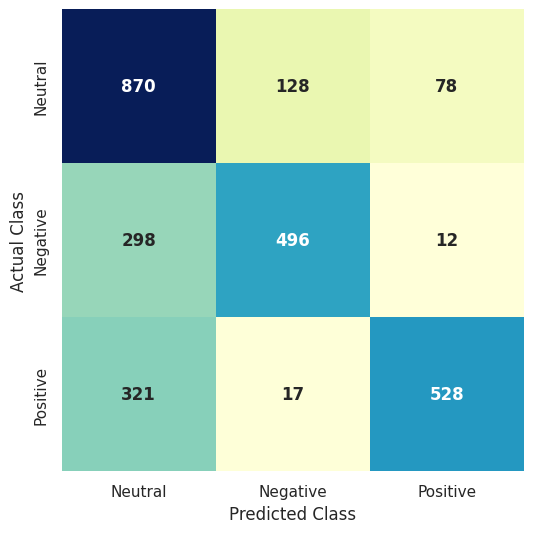

In [56]:
# defining the parameter
font_size = 12
fig_size = (6,6)

# setting the figure size
plt.figure(figsize = fig_size)

# plotting heatmap of confusion matrix
sns.heatmap(confusionMat, 
            xticklabels = target_names,
            yticklabels = target_names,
            square = True, fmt = 'd', 
            cbar = False, cmap = 'YlGnBu', 
            annot = True,
            annot_kws = {
                "fontsize": font_size,
                'fontweight': 'bold',
                },
          )

# defining the label names for X-axis and Y-axis
plt.xlabel('Predicted Class', fontsize = font_size)
plt.ylabel('Actual Class', fontsize = font_size)

# saving the plot
dpi = 1200
image_name = 'Confusion_Matrix'
image_save_path = f'{rootDir}/03. Generated Data/Plots/{image_name}'
plt.savefig(image_save_path, dpi=dpi, pad_inches=0.2, bbox_inches='tight')

<br>

## 7.3. Prediction on New Data

<br>

### 7.3.1. Creating Data

In [57]:
# defining data position
pos = 10

# collecting data from dataframe - df
new_data = df.iloc[pos]['sequence']

# reshaping the data: LSTM takes this sequence - [samples, time steps, features]
new_data = np.reshape(new_data, (1, config['max_length'] , 1))

# extracting true result
true_result_list = targets[pos]
true_class  = int( np.argmax(true_result_list) )

<br>

### 7.3.2. Predicting Class for Created Data

In [58]:
# predicting result for new_data
predicted_class = model.predict(new_data)

# extracting the index of the predicted class with maximum probability
predicted_class = int( np.argmax(predicted_class, axis=1) )

1/1 [==============================] - 1s 1s/step


<br>

### 7.3.3. Extracting Class name

In [59]:
# extracting predicted class name
predicted_class_name = target_names[predicted_class]
print(f"\n The predicted class is : '{predicted_class_name}'")

# extracting actual class name
true_class_name = target_names[true_class]
print(f"\n The actual class is : '{true_class_name}'")


 The predicted class is : 'Neutral'

 The actual class is : 'Neutral'


<br>
<br>

<a name='save_model'></a>

# 8. Save Model

In [60]:
# defining the name of the model
modelName = 'Sentiment_Analyser.h5'

# creating the path
path = f"{rootDir}/03. Generated Data/{modelName}"

# save model
model.save( filepath = path )

<br>
<br>

<a name='saving-the-required-data'></a>

# 9. Saving the required Data

In [61]:
# defining the data with tokenizer, config, and target_names
data = {
    'tokenizer': tokenizer,
    'config': config,
    'target_names': target_names
}

In [62]:
import pickle

filename = 'data.pkl'
path = f'{rootDir}/03. Generated Data/{filename}'

# open a file for writing in binary mode
with open(path, 'wb') as f:
    # serialize and save the file
    pickle.dump(data, f)